# Явное и неявное решения уравнения фильтрации однофазной жидкости в одномерном пласте

Муравцев Александр. Вариант 16

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Задание значений входных параметров и перевод единиц измерения в СИ

In [2]:
mesh_width = 5  # количество ячеек по пространству
mesh_height = 1000  # количество ячеек по времени

In [3]:
dt = 10  # сут, временной шаг
dt *= 24 * 60 * 60  # с, временной шаг

m = 0.15  # пористость

mu = 5  # мПа*с, вязкость жидкости
mu *= 1e-3  # Па*с, вязкость жидкости

k = 5  # мД, проницаемость
k *= 1e-3 * (1e-6) ** 2  # м^2, проницаемость

dx = 100  # м, длина ячейки

compr = 2.4e-9  # Па^(-1), общая сжимаемость

a_square = 10000  # м^2, площадь поверхности боковой грани ячейки

p_initial = 19  # МПа, начальное давление в ячейках
p_initial *= 1e6  # Па, начальное давление в ячейках

q_left = 6  # м^3/сут, расход на левой границе
q_left /= (24 * 60 * 60)  # м^3/с, расход на левой границе

p_right = 20  # МПа, давление на правой границе
p_right *= 1e6  # Па, давление на правой границе

## Решение явным методом

In [4]:
# безразмерный множитель, входящий в формулы явного метода
dimless_mult = (dt / dx ** 2) * (k / (m * mu * compr))
dimless_mult

0.24000000000000007

In [5]:
# задание матрицы для значений давления по координате и времени
p_explicit = np.zeros([mesh_height, mesh_width])
# задание начальных условий в узлах
p_explicit[0][:] = p_initial
p_explicit

array([[19000000., 19000000., 19000000., 19000000., 19000000.],
       [       0.,        0.,        0.,        0.,        0.],
       [       0.,        0.,        0.,        0.,        0.],
       ...,
       [       0.,        0.,        0.,        0.,        0.],
       [       0.,        0.,        0.,        0.,        0.],
       [       0.,        0.,        0.,        0.,        0.]])

In [6]:
# решение явным методом
for t_ind in range(1, mesh_height):
    p_explicit[t_ind][0] = p_explicit[t_ind - 1][0] + \
        dimless_mult * (p_explicit[t_ind - 1][1] - p_explicit[t_ind - 1][0] + q_left * mu / (a_square * k) * dx)
    p_explicit[t_ind][-1] = p_explicit[t_ind - 1][-1] + \
        4 / 3 * dimless_mult * (2 * p_right - 3 * p_explicit[t_ind - 1][-1] + p_explicit[t_ind - 1][-2])
     
    for x_ind in range(1, mesh_width - 1):
        p_explicit[t_ind][x_ind] = p_explicit[t_ind - 1][x_ind] + \
        dimless_mult * (p_explicit[t_ind - 1][x_ind + 1] - 2 * p_explicit[t_ind - 1][x_ind] + p_explicit[t_ind - 1][x_ind - 1])

In [7]:
# перевод значений давления из Па в МПа
p_explicit /= 1e6
print('Далее выведены значения давлений в нулевой, первый и второй моменты времени,'
      '\nа также значения давлений (последние 3 строки) на установившемся режиме:')
p_explicit

Далее выведены значения давлений в нулевой, первый и второй моменты времени,
а также значения давлений (последние 3 строки) на установившемся режиме:


array([[19.        , 19.        , 19.        , 19.        , 19.        ],
       [19.16666667, 19.        , 19.        , 19.        , 19.64      ],
       [19.29333333, 19.04      , 19.        , 19.1536    , 19.6656    ],
       ...,
       [23.125     , 22.43055556, 21.73611111, 21.04166667, 20.34722222],
       [23.125     , 22.43055556, 21.73611111, 21.04166667, 20.34722222],
       [23.125     , 22.43055556, 21.73611111, 21.04166667, 20.34722222]])

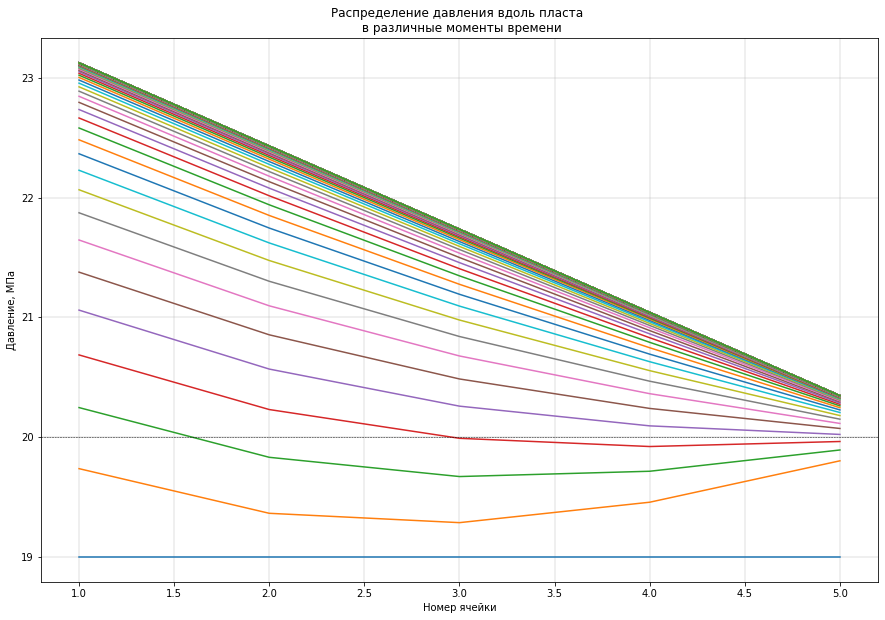

In [8]:
# построение графиков распределения давления по пласту
fig = plt.figure(figsize=(15,10))
for p_distribution in p_explicit[::7]:
    plt.plot(range(1, 6), p_distribution)

plt.title('Распределение давления вдоль пласта \n в различные моменты времени')
plt.xlabel('Номер ячейки')
plt.ylabel('Давление, МПа')

plt.axhline(y=20.0, color='black', linestyle='--', linewidth=0.5)
plt.grid(linewidth=0.4)
plt.show()

## Решение неявным методом

In [9]:
# безразмерный параметр, входящий в формулы неявного метода
gamma = (m * mu * compr / k) * (dx ** 2 / dt)
gamma

4.166666666666666

In [10]:
# задание матрицы для значений давления по координате и времени
p_implicit = np.zeros([mesh_height, mesh_width])
# задание начальных условий в узлах
p_implicit[0][:] = p_initial
p_implicit

array([[19000000., 19000000., 19000000., 19000000., 19000000.],
       [       0.,        0.,        0.,        0.,        0.],
       [       0.,        0.,        0.,        0.,        0.],
       ...,
       [       0.,        0.,        0.,        0.,        0.],
       [       0.,        0.,        0.,        0.,        0.],
       [       0.,        0.,        0.,        0.,        0.]])

In [11]:
# решение неявным методом
for t_ind in range(1, mesh_height):
    alpha = np.zeros(mesh_width)  # массив для прогоночных коэффициентов alpha
    beta = np.zeros(mesh_width)  # массив для прогоночных коэффициентов beta
    
    # прямой ход прогонки
    for x_ind in range(0, mesh_width):
        if x_ind == 0:
            a = 0
            b = -1 - gamma
            c = 1
            d = -q_left * dx * mu / (a_square * k) - gamma * p_implicit[t_ind - 1][x_ind]
        elif x_ind == mesh_width - 1:
            a = 1
            b = -3 - 3 / 4 * gamma
            c = 0
            d = -3 / 4 * gamma * p_implicit[t_ind - 1][x_ind] - 2 * p_right
        else:
            a = 1
            b = -2 - gamma
            c = 1
            d = -gamma * p_implicit[t_ind - 1][x_ind]
        
        if x_ind == 0:
            alpha[x_ind] = - c / b
            beta[x_ind] = d / b
        else:
            alpha[x_ind] = - c / (a * alpha[x_ind - 1] + b)
            beta[x_ind] = (d - a * beta[x_ind - 1]) / (a * alpha[x_ind - 1] + b)
    
    # обратный ход прогонки
    for x_ind in range(mesh_width - 1, -1, -1):
        if x_ind == mesh_width - 1:
            p_implicit[t_ind][x_ind] = beta[x_ind]
        else:
            p_implicit[t_ind][x_ind] = alpha[x_ind] * p_implicit[t_ind][x_ind + 1] + beta[x_ind]

In [12]:
# перевод значений давления из Па в МПа
p_implicit /= 1e6
print('Далее выведены значения давлений в нулевой, первый и второй моменты времени,'
      '\nа также значения давлений (последние 3 строки) на установившемся режиме:')
p_implicit

Далее выведены значения давлений в нулевой, первый и второй моменты времени,
а также значения давлений (последние 3 строки) на установившемся режиме:


array([[19.        , 19.        , 19.        , 19.        , 19.        ],
       [19.13919105, 19.02470933, 19.01318317, 19.05658689, 19.33576929],
       [19.25929732, 19.06529567, 19.04040375, 19.12893089, 19.51889142],
       ...,
       [23.125     , 22.43055556, 21.73611111, 21.04166667, 20.34722222],
       [23.125     , 22.43055556, 21.73611111, 21.04166667, 20.34722222],
       [23.125     , 22.43055556, 21.73611111, 21.04166667, 20.34722222]])

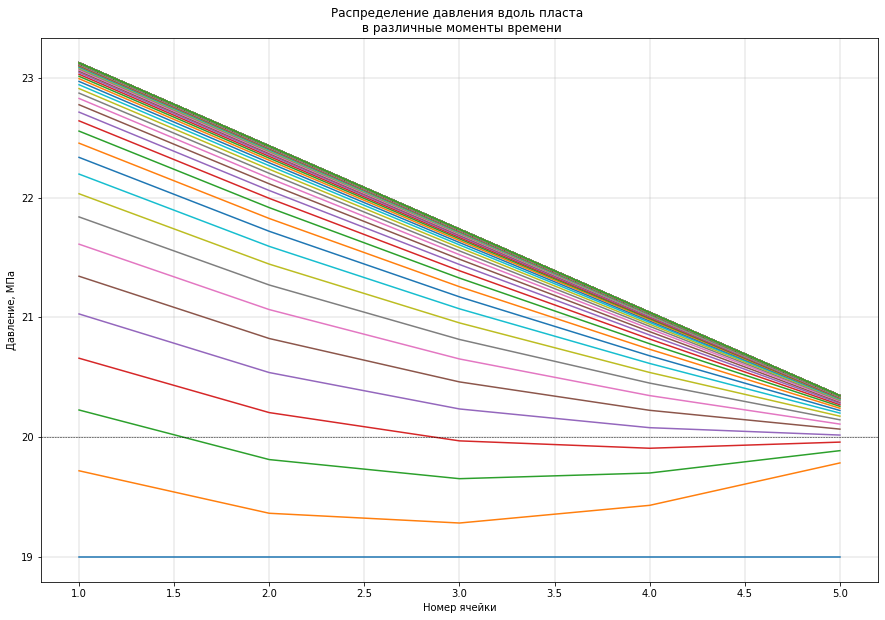

In [13]:
# построение графиков распределения давления по пласту
fig = plt.figure(figsize=(15,10))
for p_distribution in p_implicit[::7]:
    plt.plot(range(1, 6), p_distribution)

plt.title('Распределение давления вдоль пласта \n в различные моменты времени')
plt.xlabel('Номер ячейки')
plt.ylabel('Давление, МПа')

plt.axhline(y=20.0, color='black', linestyle='--', linewidth=0.5)
plt.grid(linewidth=0.4)
plt.show()

In [14]:
# разница значений давления, полученных явным и неявным методоми (в % относительно неявного метода)
implicit_explicit_diff = np.abs(p_implicit - p_explicit) / p_implicit * 100  # ошибка явного решения относительно неявного, %
implicit_explicit_diff

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.43556814e-01, 1.29880217e-01, 6.93369989e-02, 2.96941343e-01,
        1.57340889e+00],
       [1.76725086e-01, 1.32679135e-01, 2.12200055e-01, 1.28962280e-01,
        7.51623552e-01],
       ...,
       [6.16397744e-10, 5.73155888e-10, 4.69094412e-10, 3.10635214e-10,
        1.09773760e-10],
       [6.02678508e-10, 5.60421554e-10, 4.58682804e-10, 3.03729583e-10,
        1.07346759e-10],
       [5.89251170e-10, 5.47924802e-10, 4.48467334e-10, 2.96959025e-10,
        1.04954680e-10]])

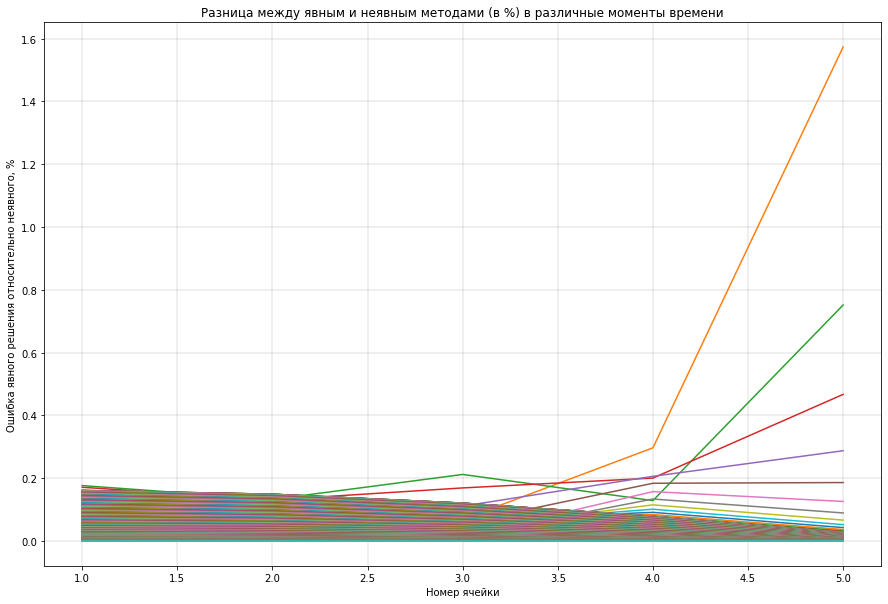

In [15]:
# построение графиков ошибки явного решения относительно неявного
fig = plt.figure(figsize=(15,10))
for error_distribution in implicit_explicit_diff:
    plt.plot(range(1, 6), error_distribution)

plt.title('Разница между явным и неявным методами (в %) в различные моменты времени')
plt.xlabel('Номер ячейки')
plt.ylabel('Ошибка явного решения относительно неявного, %')

plt.grid(linewidth=0.4)
plt.show()

## Результаты

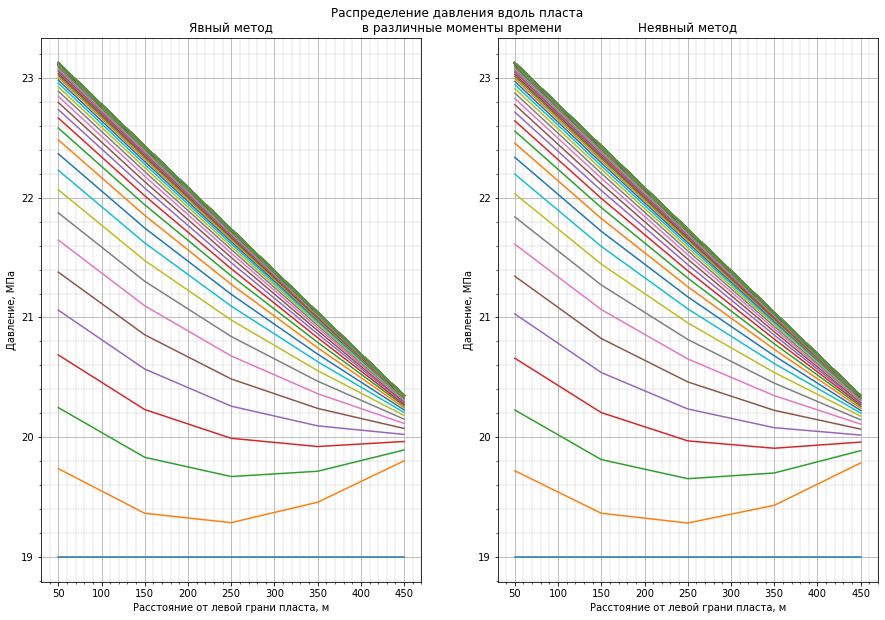

In [16]:
# совместный график явного и неявного методов
fig = plt.figure(figsize=(15,10))
plt.title('Распределение давления вдоль пласта \n в различные моменты времени')
plt.axis('off')

ax1 = fig.add_subplot(1, 2, 1)
for p_distribution in p_explicit[::7]:
    ax1.plot([(cell - 0.5) * dx for cell in range(1, 6)], p_distribution)
ax1.set_title('Явный метод')
ax1.set_xlabel('Расстояние от левой грани пласта, м')
ax1.set_ylabel('Давление, МПа')
ax1.minorticks_on()
ax1.grid(linewidth=0.8)
ax1.grid(which='minor', linewidth=0.3)

ax2 = fig.add_subplot(1, 2, 2)
for p_distribution in p_implicit[::7]:
    ax2.plot([(cell - 0.5) * dx for cell in range(1, 6)], p_distribution)
ax2.set_title('Неявный метод')
ax2.set_xlabel('Расстояние от левой грани пласта, м')
ax2.set_ylabel('Давление, МПа')
ax2.minorticks_on()
ax2.grid(linewidth=0.8)
ax2.grid(which='minor', linewidth=0.3)

plt.show()    

Критерий стабильности для явного решения:

In [17]:
print(f'dt <= {round(1 / 2 * m * mu * compr / k, 3)} * dx^2')

dt <= 180.0 * dx^2


Выполняется ли критерий?

In [18]:
dt <= 1 / 2 * (m * mu * compr / k) * dx ** 2

True

Давления по ячейкам на нулевом, первом и втором временных шагах (при решении явным методом):

In [19]:
p_explicit[0:3]

array([[19.        , 19.        , 19.        , 19.        , 19.        ],
       [19.16666667, 19.        , 19.        , 19.        , 19.64      ],
       [19.29333333, 19.04      , 19.        , 19.1536    , 19.6656    ]])

Давления по ячейкам на нулевом, первом и втором временных шагах (при решении неявным методом):

In [20]:
p_implicit[0:3]

array([[19.        , 19.        , 19.        , 19.        , 19.        ],
       [19.13919105, 19.02470933, 19.01318317, 19.05658689, 19.33576929],
       [19.25929732, 19.06529567, 19.04040375, 19.12893089, 19.51889142]])

Стационарное распределение давления:

In [21]:
p_implicit[-1]

array([23.125     , 22.43055556, 21.73611111, 21.04166667, 20.34722222])

In [22]:
p_explicit[-1]

array([23.125     , 22.43055556, 21.73611111, 21.04166667, 20.34722222])